In [35]:
import os
import numpy as np
import cv2 # OpenCV
import matplotlib.pyplot as plt

from joblib import dump, load

from htr import page_detection
from htr import word_detection
from htr import char_segmentation

from __future__ import print_function
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten

from keras.utils import to_categorical

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 5.0)


def implt(img, cmp=None, t=''):
    plt.imshow(img, cmap=cmp)
    plt.title(t)
    plt.show()

def histogram_norm(img):
    img = bilateral_norm(img)
    add_img = 255 - cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    img = 255 - img
    img = (img - np.min(img)) / (np.max(img) - np.min(img)) * 255        
    hist, bins = np.histogram(img.ravel(), 256, [0,256])
    
    img = img.astype(np.uint8)

    ret,thresh4 = cv2.threshold(img,np.argmax(hist)+10,255,cv2.THRESH_TOZERO)
    return add_img
    return cv2.add(add_img, thresh4, dtype=cv2.CV_8UC1)

def bilateral_norm(img):
    img = cv2.bilateralFilter(img, 9, 15, 30)
    return cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)

def load_image(path):
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2GRAY)

def display_image(image):
    plt.imshow(image, 'gray')
    
label_map = {1: 'а', 2: 'б', 3:'в', 4:'г', 5:'д', 6:'ђ', 7:"е", 8:'ж', 9:"з", 10:"и", 11:"ј", 12:"к", 13:"л", 14:"љ", \
             15:"м", 16:"н", 17:"њ", 18:"о", 19:"п", 20:"р", 21:"с", 22:"т", 23:"ћ", 24:"у", 25:"ф", 26:"х", 27:"ц", \
             28:"ч", 29:"џ", 30:"ш" }

In [3]:
# Load training set
NUMBER_OF_RECURRENCES = 100
NUMBER_OF_SETS = 3

train_images = []
train_labels = []

for i in range(NUMBER_OF_SETS):
    for j in range(NUMBER_OF_RECURRENCES):
        train_dir = 'training_data/mala' + str(i+1) + '/'
        count = 0
        while count <= 29:
            img_path = os.path.join(train_dir, str(count) + '.jpg')
            img = cv2.imread(img_path)
            img = cv2.resize(img,(32,32))
            train_images.append(img)
            train_labels.append(count)
            count += 1
            
    print("LOADED: training set ", i+1, '--', NUMBER_OF_RECURRENCES, 'times')

train_images = np.array(train_images)
train_labels = np.array(train_labels)

LOADED: training set  1 -- 100 times
LOADED: training set  2 -- 100 times
LOADED: training set  3 -- 100 times


In [20]:
# Load test set
test_dir = 'training_data/test_set/'
test_images = []
test_labels = []

count = 0
while count <= 29:
    img_path = os.path.join(test_dir, str(count) + '.jpg')
    img = cv2.imread(img_path)
    img = cv2.resize(img,(32,32))
    test_images.append(img)
    test_labels.append(count)
    count += 1
    
print("LOADED: test set")

test_images = np.array(test_images)
test_labels = np.array(test_labels)

LOADED: test set
30


Total number of outputs :  30
Output classes :  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]


Text(0.5,1,'Ground Truth : 0')

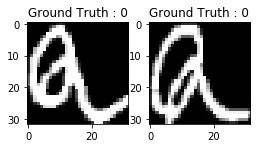

In [5]:
# Find the unique numbers from the train labels
classes = np.unique(train_labels)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

plt.figure(figsize=[4,2])

# Display the first image in training data
plt.subplot(121)
plt.imshow(train_images[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(train_labels[0]))

# Display the first image in testing data
plt.subplot(122)
plt.imshow(test_images[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(test_labels[0]))

In [24]:
# Find the shape of input images and create the variable input_shape
print(train_images.shape)
nRows,nCols,nDims = train_images.shape[1:]
train_data = train_images.reshape(train_images.shape[0], nRows, nCols, nDims)
test_data = test_images.reshape(test_images.shape[0], nRows, nCols, nDims)
input_shape = (nRows, nCols, nDims)

# Change to float datatype
train_data = train_data.astype('float32')
test_data = test_data.astype('float32')

# Scale the data to lie between 0 to 1
train_data /= 255
test_data /= 255

# Change the labels from integer to categorical data
train_labels_one_hot = to_categorical(train_labels)
test_labels_one_hot = to_categorical(test_labels)

(9000, 32, 32, 3)


In [7]:
# Display the change for category label using one-hot encoding
print('Original label 0 : ', train_labels[0])
print('After conversion to categorical ( one-hot ) : ', train_labels_one_hot[0])

Original label 0 :  0
After conversion to categorical ( one-hot ) :  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]


In [8]:
def createModel():
    model = Sequential()
    # The first two layers with 32 filters of window size 3x3
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(nClasses, activation='softmax'))
    
    return model

In [ ]:
model1 = createModel()
batch_size = 256
epochs = 50
model1.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

model1.summary()

history = model1.fit(train_data, train_labels_one_hot, batch_size=batch_size, epochs=epochs, verbose=1, 
                   validation_data=(test_data, test_labels_one_hot))
model1.evaluate(test_data, test_labels_one_hot)

In [ ]:
# Save model
dump(model1, './models/model_cnn.ai') 

In [9]:
# Load model
model1 = load('./models/model_cnn.ai') 

In [10]:
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

NameError: name 'history' is not defined

<Figure size 576x432 with 0 Axes>

In [11]:
plt.figure(figsize=[8,6])
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

NameError: name 'history' is not defined

<Figure size 576x432 with 0 Axes>

In [28]:
path = "./data/my-pages/t1.jpg"
image = page_detection.detect(path)

# Detected page
#implt(image)

# Words detected
word_imgs = word_detection.detect(image)

seg2_words = []
seg_words = []

for word in word_imgs:
    # Select some word
    img_copy = word.copy()
    #implt(img_copy, cmp='gray', t='Original word')
    # Segment it
    segments = char_segmentation.segment(img_copy)
    seg2_words.append(segments)

for s in seg2_words:
    new_segment = []
    for c in s:
        img = cv2.resize(c, (32, 32))
        img = cv2.cvtColor(img ,cv2.COLOR_GRAY2RGB)
        new_segment.append(img)
    seg_words.append(np.array(new_segment))
    
seg_words = np.array(seg_words)
#for s in segments:
#    implt(s, cmp='gray', t='Char')

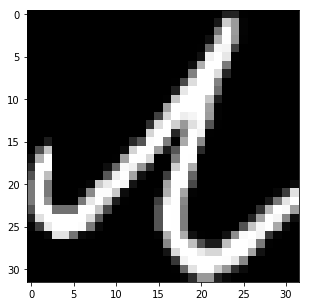

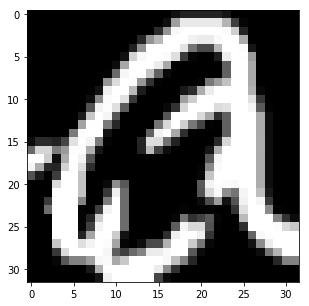

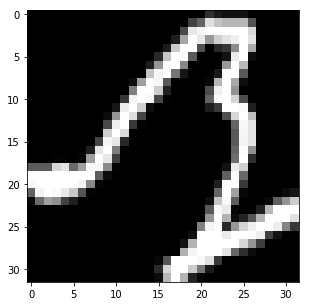

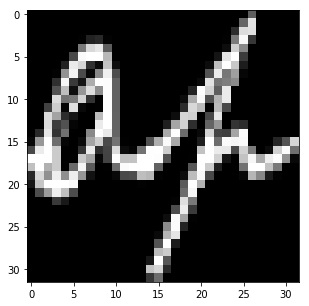

т
з
з
ж


In [39]:
predict_images = seg_words[3]

for p in predict_images:
    implt(p, 'gray')

nRows,nCols,nDims = predict_images.shape[1:]
    
predict_data = predict_images.reshape(predict_images.shape[0], nRows, nCols, nDims)
input_shape = (nRows, nCols, nDims)

# Change to float datatype
predict_data = predict_data.astype('float32')

# Scale the data to lie between 0 to 1
predict_data /= 255

t =  model1.predict(predict_data)
t = t.astype('int32')

for data in t:
    for i in range(len(data)):
        if data[i]:
            print(label_map[i+1])
            


